### Gapfilling preprocess
Notebook to process the Gapfilling data and extract the data from it, for the three different subbasins

In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import getpass
import xarray as xr
!python -m pip install motuclient==1.8.4 --no-cache-dir
import motuclient
import xarray as xr
import numpy as np
!python -m pip install ffmpeg==1.4
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import pandas as pd
!python -m pip install rioxarray
import rioxarray
import rasterio as rio
import rasterio.plot
!python -m pip install netCDF4
import netCDF4
!python -m pip install h5netcdf
import h5netcdf
import random
from skimage import io as skio
import ffmpeg
import matplotlib.gridspec as gridspec
import subprocess
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#from numba import jit, cuda
import tifffile
from tqdm import tqdm
import skimage.transform as sktransform
import tensorflow as tf
!pip install dask==2022.12.1
import dask
!pip install basemap
from mpl_toolkits.basemap import Basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for motuclient: filename=motuclient-1.8.4-py3-none-any.whl size=32873 sha256=29a59c7ee03dc56fc02d60393e0e24165bdc3ee59d9d1eb011ae511ae065a054
  Stored in directory: /tmp/pip-ephem-wheel-cache-a3aqleb5/wheels/46/74/d1/ee3216f52d83212f10a0a5f5b94f3d99cf3d29b8ecf09c60b6
Successfully built motuclient
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=dde19be49a13a057890096f00eadcc69fe5f43c0fdd8b535479b9a429d5dcc5b
  Stored in directory: /root/.cache/pip/wheels/8e/7a/69/cd6aeb83b126a7f04cbe7c9d929028dc52a6e7d525ff56003a
Successfully built ffmpeg
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load all data into the notebook, reproject and resample the mask data and then use the mask to only keep the data of the Baltic Sea for further analysis

In [3]:
chl_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km'
values_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_BS'
valuesRiga_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Riga'
valuesKattegat_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Kattegat'
valuesGotland_dir = r'/content/drive/MyDrive/MasterThesis/Data/CHL_1km/values_Gotland'
mask_dir = r'/content/drive/MyDrive/MasterThesis/Data/land_mask/iowtopo2_rev03.nc'
chl_dir_olci = r'/content/drive/MyDrive/MasterThesis/Data/CHL_300m'

In [5]:
mask_data= xr.open_dataset(f"{mask_dir}")
mask_data = mask_data.rename_dims({'XT_I': 'x', 'YT_J': 'y'}).rename_vars({"XT_I": "x", "YT_J": "y"}).set_coords(["x", "y"])
chl_data = xr.open_mfdataset(f"{chl_dir}/CHL_data_"+"*.nc", decode_coords="all")
chl_data = chl_data.sel(time=~chl_data.get_index("time").duplicated())
chl_data = chl_data.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])
chl_data_temp = chl_data.isel(time=0)

Exception ignored in: <function CachingFileManager.__del__ at 0x7fa684a37c70>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 248, in __del__
  File "/usr/local/lib/python3.10/dist-packages/xarray/backends/file_manager.py", line 232, in close
  File "/usr/local/lib/python3.10/dist-packages/scipy/io/_netcdf.py", line 313, in close
OSError: [Errno 107] Transport endpoint is not connected


In [6]:
chl_data

<xarray.Dataset>
Dimensions:  (time: 8821, y: 1147, x: 1185)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-06 ... 2021-12-31
  * y        (y) float32 53.26 53.27 53.28 53.29 ... 65.81 65.82 65.83 65.84
  * x        (x) float32 9.259 9.277 9.294 9.312 ... 30.19 30.21 30.22 30.24
Data variables:
    CHL      (time, y, x) float32 dask.array<chunksize=(7, 1147, 1185), meta=np.ndarray>
Attributes: (12/42)
    Conventions:             CF-1.4
    references:              
    institution:             CNR-GOS
    contact:                 technical@gos.artov.isac.cnr.it
    netcdf_version:          v4
    grid_mapping:            Equirectangular
    ...                      ...
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    History:                 Translated to CF-1.0 Conventions by Netcdf-Java ...
    geospatial_lat_min:      53.2554931640625
    geospatial_lat_max:      65.8445053100586
    geospatial_lon_min:      9.25886058807373
    geospatial_lon_max:      30.241138458251953



Check for missing time steps and fill missing times with NaN data



In [7]:
# Boundary dates
start_date = datetime(1997, 9, 4, 0)
end_date = datetime(2021, 12, 31, 0)


# delta time
delta_t = start_date-end_date   # d+daydays to download by request
print(delta_t)

-8884 days, 0:00:00


In [8]:
# Define expected time range
expected_times = pd.date_range(start='1997-09-04', end='2021-12-31', freq='D')

# Check for missing times
missing_times = expected_times.difference(chl_data.time.values)
if len(missing_times) > 0:
    print("The following times are missing:")
    print(missing_times)
else:
    print("All expected times are present in the dataset.")

The following times are missing:
DatetimeIndex(['1997-09-05', '1997-09-07', '1997-09-08', '1997-09-11',
               '1997-09-12', '1997-09-13', '1997-09-14', '1997-09-17',
               '1997-10-13', '1997-10-14', '1997-10-15', '1997-10-16',
               '1997-10-17', '1997-10-18', '1997-12-15', '1998-07-10',
               '1998-11-17', '1998-11-18', '1998-11-19', '1998-11-20',
               '1998-12-17', '1999-01-25', '1999-11-17', '1999-11-18',
               '2000-11-17', '2001-11-18', '2008-10-31', '2008-11-01',
               '2008-11-02', '2008-11-03', '2008-11-04', '2008-11-05',
               '2008-11-06', '2008-11-07', '2008-11-08', '2008-11-09',
               '2008-11-10', '2008-11-11', '2008-11-12', '2008-11-13',
               '2008-11-14', '2008-11-15', '2008-11-16', '2008-11-17',
               '2008-11-18', '2012-08-11', '2012-08-12', '2012-08-13',
               '2012-08-14', '2012-08-15', '2012-08-16', '2012-08-17',
               '2012-08-18', '2012-08-19', '

In [9]:
# Fill gaps with NaN values
chl_data = chl_data.reindex(time=expected_times)
chl_data

<xarray.Dataset>
Dimensions:  (time: 8885, y: 1147, x: 1185)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-05 ... 2021-12-31
  * y        (y) float32 53.26 53.27 53.28 53.29 ... 65.81 65.82 65.83 65.84
  * x        (x) float32 9.259 9.277 9.294 9.312 ... 30.19 30.21 30.22 30.24
Data variables:
    CHL      (time, y, x) float32 dask.array<chunksize=(15, 1147, 1185), meta=np.ndarray>
Attributes: (12/42)
    Conventions:             CF-1.4
    references:              
    institution:             CNR-GOS
    contact:                 technical@gos.artov.isac.cnr.it
    netcdf_version:          v4
    grid_mapping:            Equirectangular
    ...                      ...
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    History:                 Translated to CF-1.0 Conventions by Netcdf-Java ...
    geospatial_lat_min:      53.2554931640625
    geospatial_lat_max:      65.8445053100586
    geospatial_lon_min:      9.25886058807373
    geospatial_lon_max:      30.241138458251953

In [10]:
# Resample the smaller dataset to match the dimensions of the larger dataset
mask_data_resampled = mask_data.interp_like(chl_data_temp, method='nearest')

# Close the datasets
mask_data.close()
chl_data.close()
mask_data_resampled.close()

# look at reprojected mask data
mask_data_resampled

<xarray.Dataset>
Dimensions:    (x: 1185, bnds: 2, y: 1147)
Coordinates:
  * x          (x) float32 9.259 9.277 9.294 9.312 ... 30.19 30.21 30.22 30.24
  * y          (y) float32 53.26 53.27 53.28 53.29 ... 65.81 65.82 65.83 65.84
Dimensions without coordinates: bnds
Data variables: (12/14)
    XT_I_bnds  (x, bnds) float64 9.233 9.267 9.267 9.3 ... 30.23 30.23 30.27
    YT_J_bnds  (y, bnds) float64 nan nan nan nan nan ... 65.83 65.85 65.83 65.85
    Z_TOPO     (y, x) float32 nan nan nan nan nan ... 274.0 305.8 305.8 294.3
    Z_WATER    (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    Z_LAND     (y, x) float32 nan nan nan nan nan ... 274.0 305.8 305.8 294.3
    Z_MIN      (y, x) float32 nan nan nan nan nan ... 271.0 273.0 273.0 271.0
    ...         ...
    Z_NEAR     (y, x) float32 nan nan nan nan nan ... 277.0 367.0 367.0 299.0
    D_NEAR     (y, x) float32 nan nan nan nan ... 0.5009 0.5008 0.5008 0.5009
    N_WET      (y, x) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    N_DRY      (y, x) float32 nan nan nan nan nan nan ... 8.0 8.0 8.0 8.0 8.0
    LANDMASK   (y, x) float32 nan nan nan nan nan nan ... 1.0 1.0 1.0 1.0 1.0
    FLAG       (y, x) float32 nan nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    history:  Thu Jun 21 18:41:58 2007: ncks -A -a -x -v Z_TOPO,Z_WATER /silo...
    title:    IOW Baltic Sea Topography

## Overview of three different areas

In [11]:
riga_range_x  = range(720,880,1)
riga_range_y = range(330,490,1)

kattegat_range_x  = range(50,210,1)
kattegat_range_y = range(200,360,1)

gotland_range_x  = range(470,630,1)
gotland_range_y = range(160,320,1)

In [ ]:
data_RIGA = chl_data.isel(x=riga_range_x, y= riga_range_y)
data_RIGA

<xarray.Dataset>
Dimensions:  (time: 8885, y: 160, x: 160)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-05 ... 2021-12-31
  * y        (y) float32 56.88 56.89 56.9 56.91 ... 58.59 58.61 58.62 58.63
  * x        (x) float32 22.02 22.04 22.05 22.07 ... 24.78 24.8 24.82 24.84
Data variables:
    CHL      (time, y, x) float32 dask.array<chunksize=(15, 160, 160), meta=np.ndarray>
Attributes: (12/42)
    Conventions:             CF-1.4
    references:              
    institution:             CNR-GOS
    contact:                 technical@gos.artov.isac.cnr.it
    netcdf_version:          v4
    grid_mapping:            Equirectangular
    ...                      ...
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    History:                 Translated to CF-1.0 Conventions by Netcdf-Java ...
    geospatial_lat_min:      53.2554931640625
    geospatial_lat_max:      65.8445053100586
    geospatial_lon_min:      9.25886058807373
    geospatial_lon_max:      30.241138458251953

In [ ]:
data_kattegat = chl_data.isel(x=kattegat_range_x, y= kattegat_range_y)
data_kattegat

<xarray.Dataset>
Dimensions:  (time: 8885, y: 160, x: 160)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-05 ... 2021-12-31
  * y        (y) float32 55.45 55.46 55.47 55.49 55.5 ... 57.17 57.18 57.19 57.2
  * x        (x) float32 10.14 10.16 10.18 10.2 ... 12.91 12.93 12.94 12.96
Data variables:
    CHL      (time, y, x) float32 dask.array<chunksize=(15, 160, 160), meta=np.ndarray>
Attributes: (12/42)
    Conventions:             CF-1.4
    references:              
    institution:             CNR-GOS
    contact:                 technical@gos.artov.isac.cnr.it
    netcdf_version:          v4
    grid_mapping:            Equirectangular
    ...                      ...
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    History:                 Translated to CF-1.0 Conventions by Netcdf-Java ...
    geospatial_lat_min:      53.2554931640625
    geospatial_lat_max:      65.8445053100586
    geospatial_lon_min:      9.25886058807373
    geospatial_lon_max:      30.241138458251953

In [ ]:
data_gotland = chl_data.isel(x=gotland_range_x, y= gotland_range_y)
data_gotland

<xarray.Dataset>
Dimensions:  (time: 8885, y: 160, x: 160)
Coordinates:
  * time     (time) datetime64[ns] 1997-09-04 1997-09-05 ... 2021-12-31
  * y        (y) float32 55.01 55.02 55.04 55.05 ... 56.73 56.74 56.75 56.76
  * x        (x) float32 17.59 17.61 17.62 17.64 ... 20.35 20.37 20.39 20.41
Data variables:
    CHL      (time, y, x) float32 dask.array<chunksize=(15, 160, 160), meta=np.ndarray>
Attributes: (12/42)
    Conventions:             CF-1.4
    references:              
    institution:             CNR-GOS
    contact:                 technical@gos.artov.isac.cnr.it
    netcdf_version:          v4
    grid_mapping:            Equirectangular
    ...                      ...
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    History:                 Translated to CF-1.0 Conventions by Netcdf-Java ...
    geospatial_lat_min:      53.2554931640625
    geospatial_lat_max:      65.8445053100586
    geospatial_lon_min:      9.25886058807373
    geospatial_lon_max:      30.241138458251953

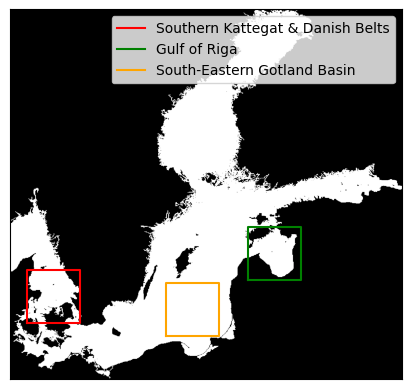

In [ ]:
# area of kattegat waters, denmark
coord_dk = [[50,170], [50,330], [210,330], [210,170]]
coord_dk.append(coord_dk[0])
xs_dk, ys_dk = zip(*coord_dk)
# area of golf of riga
coord_rg = [[720,300], [720,460], [880,460], [880,300]]
coord_rg.append(coord_rg[0])
xs_rg, ys_rg = zip(*coord_rg)
# area of bothnian sea
coord_bb = [[470,130], [470,290], [630,290], [630,130]]
coord_bb.append(coord_bb[0])
xs_bb, ys_bb = zip(*coord_bb)


plt.figure()
plt.imshow(mask_data_resampled.LANDMASK[30:,:], origin='lower', cmap='Greys')
plt.plot(xs_dk,ys_dk, color='red', label='Southern Kattegat & Danish Belts')
plt.plot(xs_rg,ys_rg, color='green', label='Gulf of Riga')
plt.plot(xs_bb,ys_bb, color='orange', label='South-Eastern Gotland Basin')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

## Extracting the values for the different areas

### Multi data

In [ ]:
j = 0
# extract the values from the data
#normal_data_RIGA = np.empty((0,1147,1185))
for i in tqdm(range(0,8885,1000)): #26983
  if i+1000>8885:
    chl_data_ = chl_data.isel(time=range(i,8885,1))
  else:
    chl_data_ = chl_data.isel(time=range(i,i+1000,1))
  chl_data_RIGA = chl_data_.isel(x=riga_range_x, y= riga_range_y)
  chl_data_KTT = chl_data_.isel(x=kattegat_range_x, y= kattegat_range_y)
  chl_data_GTL = chl_data_.isel(x=gotland_range_x, y= gotland_range_y)
  CHL_RIGA = chl_data_RIGA['CHL'].values
  CHL_KTT = chl_data_KTT['CHL'].values
  CHL_GTL = chl_data_GTL['CHL'].values
  print(CHL.shape)
  np.save(f'{valuesRiga_dir}/CHL_data_multi_{j}.npy', CHL_RIGA)
  np.save(f'{valuesKattegat_dir}/CHL_data_multi_{j}.npy', CHL_KTT)
  np.save(f'{valuesGotland_dir}/CHL_data_multi_{j}.npy', CHL_GTL)
  j += 1

  0%|          | 0/9 [00:00<?, ?it/s]

(1000, 160, 160)


 11%|█         | 1/9 [00:51<06:50, 51.36s/it]

(1000, 160, 160)


 22%|██▏       | 2/9 [02:04<07:30, 64.41s/it]

(1000, 160, 160)


 33%|███▎      | 3/9 [02:55<05:48, 58.12s/it]

(1000, 160, 160)


 44%|████▍     | 4/9 [03:50<04:43, 56.68s/it]

(1000, 160, 160)


 56%|█████▌    | 5/9 [04:41<03:39, 54.86s/it]

(1000, 160, 160)


 67%|██████▋   | 6/9 [05:35<02:43, 54.59s/it]

(1000, 160, 160)


 78%|███████▊  | 7/9 [06:32<01:50, 55.43s/it]

(1000, 160, 160)


 89%|████████▉ | 8/9 [07:29<00:55, 55.91s/it]

(1000, 160, 160)


100%|██████████| 9/9 [08:25<00:00, 56.20s/it]


### OLCI L3 data

In [ ]:
j = 7
for year in tqdm(range(2016,2024,1)):
  chl_data_olci = xr.open_mfdataset(f"{chl_dir_olci}/CHL_data_"+f"*{year}.nc", decode_coords="all")
  chl_data_olci = chl_data_olci.sel(time=~chl_data_olci.get_index("time").duplicated())
  # Rename the dimension
  chl_data_olci = chl_data_olci.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])

  # Define expected time range
  if year == 2016:
    expected_times = pd.date_range(start='2016-05-01', end='2016-12-27', freq='D')
  if year == 2017:
    chl_data_olci = chl_data_olci.sel(time=slice('2016-12-28', '2017-12-22'))
    expected_times = pd.date_range(start='2016-12-28', end='2017-12-22', freq='D')
  if year == 2018:
    chl_data_olci = chl_data_olci.sel(time=slice('2017-12-23', '2018-12-17'))
    expected_times = pd.date_range(start='2017-12-23', end='2018-12-17', freq='D')
  if year == 2019:
    chl_data_olci = chl_data_olci.sel(time=slice('2018-12-18', '2019-12-12'))
    expected_times = pd.date_range(start='2018-12-18', end='2019-12-12', freq='D')
  if year == 2020:
    chl_data_olci = chl_data_olci.sel(time=slice('2019-12-13', '2020-12-26'))
    expected_times = pd.date_range(start='2019-12-13', end='2020-12-26', freq='D')
  if year == 2021:
    chl_data_olci = chl_data_olci.sel(time=slice('2020-12-27', '2021-12-21'))
    expected_times = pd.date_range(start='2020-12-27', end='2021-12-21', freq='D')
  if year == 2022:
    chl_data_olci = chl_data_olci.sel(time=slice('2021-12-22', '2022-12-16'))
    expected_times = pd.date_range(start='2021-12-22', end='2022-12-16', freq='D')
  if year == 2023:
    chl_data_olci = chl_data_olci.sel(time=slice('2022-12-17', '2023-04-15'))
    expected_times = pd.date_range(start='2022-12-17', end='2023-04-15', freq='D')

  # Check for missing times
  missing_times = expected_times.difference(chl_data_olci.time.values)
  if len(missing_times) > 0:
      print("The following times are missing:")
      print(missing_times)
  else:
      print("All expected times are present in the dataset.")

  # Fill gaps with NaN values
  chl_data_olci = chl_data_olci.reindex(time=expected_times)

  # Select the lat and lon coordinates from one of the datasets
  lat_lon_subset = chl_data[['x', 'y']]

  # Interpolate the second dataset to the grid of the first dataset
  chl_data_olci_interp = chl_data_olci.interp_like(lat_lon_subset, )

  # cut to size of subarea
  chl_data_RIGA = chl_data_olci_interp.isel(x=riga_range_x, y= riga_range_y)
  chl_data_KTT = chl_data_olci_interp.isel(x=kattegat_range_x, y= kattegat_range_y)
  chl_data_GTL = chl_data_olci_interp.isel(x=gotland_range_x, y= gotland_range_y)

  # extract the values
  CHL_RIGA = chl_data_RIGA['CHL'].values
  CHL_KTT = chl_data_KTT['CHL'].values
  CHL_GTL = chl_data_GTL['CHL'].values

  # set threshold just on Riga data
  CHL_RIGA = np.where(CHL_RIGA < 1, np.nan, CHL_RIGA)

  print(CHL_RIGA.shape)
  np.save(f'{valuesRiga_dir}/CHL_data_{j}.npy', CHL_RIGA)
  np.save(f'{valuesKattegat_dir}/CHL_data_{j}.npy', CHL_KTT)
  np.save(f'{valuesGotland_dir}/CHL_data_{j}.npy', CHL_GTL)
  j += 1

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2016-05-09', '2016-06-01', '2016-06-05', '2016-06-22',
               '2016-06-25', '2016-07-02', '2016-07-14', '2016-07-23',
               '2016-07-25', '2016-08-07', '2016-08-10', '2016-08-15',
               '2016-09-07', '2016-09-17', '2016-10-14', '2016-12-07',
               '2016-12-08', '2016-12-11', '2016-12-15', '2016-12-18',
               '2016-12-19', '2016-12-20'],
              dtype='datetime64[ns]', freq=None)


 12%|█▎        | 1/8 [10:48<1:15:42, 648.98s/it]

(241, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-07', '2017-01-11',
               '2017-01-30', '2017-02-26', '2017-03-02', '2017-03-25',
               '2017-03-29', '2017-04-11', '2017-04-26', '2017-05-18',
               '2017-05-22', '2017-07-06', '2017-07-30', '2017-08-11',
               '2017-09-03', '2017-10-16', '2017-10-31', '2017-11-23',
               '2017-11-27', '2017-12-20'],
              dtype='datetime64[ns]', freq=None)
(360, 160, 160)


 25%|██▌       | 2/8 [26:18<1:21:22, 813.78s/it]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2017-12-24', '2018-01-16', '2018-07-19', '2018-09-11',
               '2018-12-06'],
              dtype='datetime64[ns]', freq=None)
(360, 160, 160)


 38%|███▊      | 3/8 [41:49<1:12:18, 867.65s/it]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


All expected times are present in the dataset.
(360, 160, 160)


 50%|█████     | 4/8 [58:22<1:01:07, 916.91s/it]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2019-12-30', '2020-01-12', '2020-04-11', '2020-05-06',
               '2020-05-24', '2020-07-29', '2020-08-28', '2020-08-31'],
              dtype='datetime64[ns]', freq=None)
(380, 160, 160)


 62%|██████▎   | 5/8 [1:15:34<47:55, 958.42s/it]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2021-03-05', '2021-05-15', '2021-06-07', '2021-06-26',
               '2021-07-31', '2021-08-15', '2021-08-17'],
              dtype='datetime64[ns]', freq=None)
(360, 160, 160)


 75%|███████▌  | 6/8 [1:31:48<32:07, 963.79s/it]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


All expected times are present in the dataset.
(360, 160, 160)


 88%|████████▊ | 7/8 [1:48:48<16:22, 982.29s/it]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2023-02-27'], dtype='datetime64[ns]', freq=None)


100%|██████████| 8/8 [1:54:02<00:00, 855.29s/it]

(120, 160, 160)


## Olci-Data, Riga without threshold

In [12]:
j = 7
for year in tqdm(range(2016,2024,1)):
  chl_data_olci = xr.open_mfdataset(f"{chl_dir_olci}/CHL_data_"+f"*{year}.nc", decode_coords="all")
  chl_data_olci = chl_data_olci.sel(time=~chl_data_olci.get_index("time").duplicated())
  # Rename the dimension
  chl_data_olci = chl_data_olci.rename_dims({'lon': 'x', 'lat': 'y'}).rename_vars({"lon": "x", "lat": "y"}).set_coords(["x", "y"])

  # Define expected time range
  if year == 2016:
    expected_times = pd.date_range(start='2016-05-01', end='2016-12-27', freq='D')
  if year == 2017:
    chl_data_olci = chl_data_olci.sel(time=slice('2016-12-28', '2017-12-22'))
    expected_times = pd.date_range(start='2016-12-28', end='2017-12-22', freq='D')
  if year == 2018:
    chl_data_olci = chl_data_olci.sel(time=slice('2017-12-23', '2018-12-17'))
    expected_times = pd.date_range(start='2017-12-23', end='2018-12-17', freq='D')
  if year == 2019:
    chl_data_olci = chl_data_olci.sel(time=slice('2018-12-18', '2019-12-12'))
    expected_times = pd.date_range(start='2018-12-18', end='2019-12-12', freq='D')
  if year == 2020:
    chl_data_olci = chl_data_olci.sel(time=slice('2019-12-13', '2020-12-26'))
    expected_times = pd.date_range(start='2019-12-13', end='2020-12-26', freq='D')
  if year == 2021:
    chl_data_olci = chl_data_olci.sel(time=slice('2020-12-27', '2021-12-21'))
    expected_times = pd.date_range(start='2020-12-27', end='2021-12-21', freq='D')
  if year == 2022:
    chl_data_olci = chl_data_olci.sel(time=slice('2021-12-22', '2022-12-16'))
    expected_times = pd.date_range(start='2021-12-22', end='2022-12-16', freq='D')
  if year == 2023:
    chl_data_olci = chl_data_olci.sel(time=slice('2022-12-17', '2023-04-15'))
    expected_times = pd.date_range(start='2022-12-17', end='2023-04-15', freq='D')

  # Check for missing times
  missing_times = expected_times.difference(chl_data_olci.time.values)
  if len(missing_times) > 0:
      print("The following times are missing:")
      print(missing_times)
  else:
      print("All expected times are present in the dataset.")

  # Fill gaps with NaN values
  chl_data_olci = chl_data_olci.reindex(time=expected_times)

  # Select the lat and lon coordinates from one of the datasets
  lat_lon_subset = chl_data[['x', 'y']]

  # Interpolate the second dataset to the grid of the first dataset
  chl_data_olci_interp = chl_data_olci.interp_like(lat_lon_subset, )

  # cut to size of subarea
  chl_data_RIGA = chl_data_olci_interp.isel(x=riga_range_x, y= riga_range_y)

  # extract the values
  CHL_RIGA = chl_data_RIGA['CHL'].values

  print(CHL_RIGA.shape)
  np.save(f'{valuesRiga_dir}/CHL_data_olci_nothreshold_{j}.npy', CHL_RIGA)
  j += 1

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2016-05-09', '2016-06-01', '2016-06-05', '2016-06-22',
               '2016-06-25', '2016-07-02', '2016-07-14', '2016-07-23',
               '2016-07-25', '2016-08-07', '2016-08-10', '2016-08-15',
               '2016-09-07', '2016-09-17', '2016-10-14', '2016-12-07',
               '2016-12-08', '2016-12-11', '2016-12-15', '2016-12-18',
               '2016-12-19', '2016-12-20'],
              dtype='datetime64[ns]', freq=None)


 12%|█▎        | 1/8 [03:33<24:53, 213.35s/it]

(241, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2017-01-02', '2017-01-03', '2017-01-07', '2017-01-11',
               '2017-01-30', '2017-02-26', '2017-03-02', '2017-03-25',
               '2017-03-29', '2017-04-11', '2017-04-26', '2017-05-18',
               '2017-05-22', '2017-07-06', '2017-07-30', '2017-08-11',
               '2017-09-03', '2017-10-16', '2017-10-31', '2017-11-23',
               '2017-11-27', '2017-12-20'],
              dtype='datetime64[ns]', freq=None)


 25%|██▌       | 2/8 [09:11<28:41, 286.89s/it]

(360, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2017-12-24', '2018-01-16', '2018-07-19', '2018-09-11',
               '2018-12-06'],
              dtype='datetime64[ns]', freq=None)


 38%|███▊      | 3/8 [14:16<24:35, 295.12s/it]

(360, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


All expected times are present in the dataset.


 50%|█████     | 4/8 [19:36<20:19, 304.84s/it]

(360, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2019-12-30', '2020-01-12', '2020-04-11', '2020-05-06',
               '2020-05-24', '2020-07-29', '2020-08-28', '2020-08-31'],
              dtype='datetime64[ns]', freq=None)


 62%|██████▎   | 5/8 [25:14<15:50, 316.69s/it]

(380, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2021-03-05', '2021-05-15', '2021-06-07', '2021-06-26',
               '2021-07-31', '2021-08-15', '2021-08-17'],
              dtype='datetime64[ns]', freq=None)


 75%|███████▌  | 6/8 [30:35<10:36, 318.41s/it]

(360, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


All expected times are present in the dataset.


 88%|████████▊ | 7/8 [36:14<05:24, 324.91s/it]

(360, 160, 160)


/usr/local/lib/python3.10/dist-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


The following times are missing:
DatetimeIndex(['2023-02-27'], dtype='datetime64[ns]', freq=None)


100%|██████████| 8/8 [38:06<00:00, 285.81s/it]

(120, 160, 160)


In [ ]:
# save lon and lat for Gulf of Riga
chl_data_RIGA = chl_data.isel(x=riga_range_x, y= riga_range_y)
latitudes = chl_data_RIGA ['y'].values
longitudes = chl_data_RIGA ['x'].values
np.savetxt(f'{valuesRiga_dir}/latitudes.txt',latitudes)
np.savetxt(f'{valuesRiga_dir}/longitudes.txt',longitudes)

# save lon and lat for Kattegat
chl_data_KTT = chl_data.isel(x=kattegat_range_x, y= kattegat_range_y)
latitudes = chl_data_KTT['y'].values
longitudes = chl_data_KTT['x'].values
np.savetxt(f'{valuesKattegat_dir}/latitudes.txt',latitudes)
np.savetxt(f'{valuesKattegat_dir}/longitudes.txt',longitudes)

# save lon and lat for Gotland
chl_data_GTL = chl_data.isel(x=gotland_range_x, y= gotland_range_y)
latitudes = chl_data_GTL['y'].values
longitudes = chl_data_GTL['x'].values
np.savetxt(f'{valuesGotland_dir}/latitudes.txt',latitudes)
np.savetxt(f'{valuesGotland_dir}/longitudes.txt',longitudes)

# save mask for Gulf of Riga
mask_RIGA = mask_data_resampled.isel(x=riga_range_x, y= riga_range_y)
np.save(f'{valuesRiga_dir}/mask.npy', mask_RIGA.LANDMASK.data)

# save mask for Kattegat
mask_KTT = mask_data_resampled.isel(x=kattegat_range_x, y= kattegat_range_y)
np.save(f'{valuesKattegat_dir}/mask.npy', mask_KTT.LANDMASK.data)

# save mask for Gotland
mask_GTL = mask_data_resampled.isel(x=gotland_range_x, y= gotland_range_y)
np.save(f'{valuesGotland_dir}/mask.npy', mask_GTL.LANDMASK.data)

# save time arrays in all directories
time_array_multi = pd.date_range(start='1997-09-04', end='2021-12-31', freq='D')
time_array_olci = pd.date_range(start='2016-05-01', end='2023-04-15', freq='D')

np.savetxt(f'{valuesRiga_dir}/timeframe_multi.txt',time_array_multi)
np.savetxt(f'{valuesRiga_dir}/timeframe_olci.txt',time_array_olci)
np.savetxt(f'{valuesKattegat_dir}/timeframe_multi.txt',time_array_multi)
np.savetxt(f'{valuesKattegat_dir}/timeframe_olci.txt',time_array_olci)
np.savetxt(f'{valuesGotland_dir}/timeframe_multi.txt',time_array_multi)
np.savetxt(f'{valuesGotland_dir}/timeframe_olci.txt',time_array_olci)

In [ ]:
# Calculate the average for the entire region

# region 1 : Denmarks waters
dnmk_pixels_chl_data = chl_data_denmark.count(dim=["x", "y"]) #where("x" >= 9.259 & "x" <= 13.5 & "y" >= 53.26 & "y" <= 60)

/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.Dataset>
Dimensions:  (time: 2071)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-01 2016-05-02 ... 2021-12-31
Data variables:
    CHL      (time) int64 dask.array<chunksize=(21,), meta=np.ndarray>

Text(0.5, 1.0, 'Available pixels Denmark region')

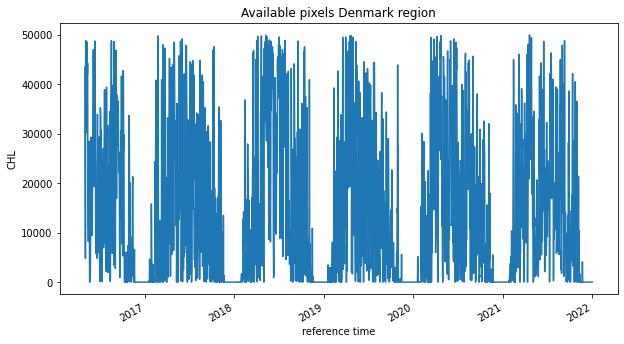

In [ ]:
dnmk_pixels_chl_data["CHL"].plot(aspect=2, size=5)
plt.title("Available pixels Denmark region")

### Gulf of Riga

In [ ]:
riga_range_x  = range(720,880,1)
riga_range_y = range(330,490,1)

# extract the values from the data
normal_data_RIGA = np.empty((0,1147,1185))
for i in tqdm(range(0,8885,200)): #26983
  if i+200>8885:
    chl_data_ = chl_data.isel(time=range(i,8885,1))
  else:
    chl_data_ = chl_data.isel(time=range(i,i+200,1))
  chl_data_RIGA = chl_data_.isel(x=riga_range_x, y= riga_range_y)
  CHL = chl_data_RIGA['CHL'].values
  print(CHL.shape)
  normal_data_RIGA = np.append(normal_data_RIGA, CHL, axis=0)

In [ ]:
# Calculate the average for the entire region

# region 2 :
goRiga_chl_data = chl_data.isel(x=range(720,880,1), y= range(330,490,1)).count(dim=["x", "y"]) #where("x" >= 9.259 & "x" <= 13.5 & "y" >= 53.26 & "y" <= 60)
goRiga_chl_data

/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


<xarray.Dataset>
Dimensions:  (time: 2071)
Coordinates:
  * time     (time) datetime64[ns] 2016-05-01 2016-05-02 ... 2021-12-31
Data variables:
    CHL      (time) int64 dask.array<chunksize=(21,), meta=np.ndarray>

Text(0.5, 1.0, 'Available pixels for Gulf of Riga')

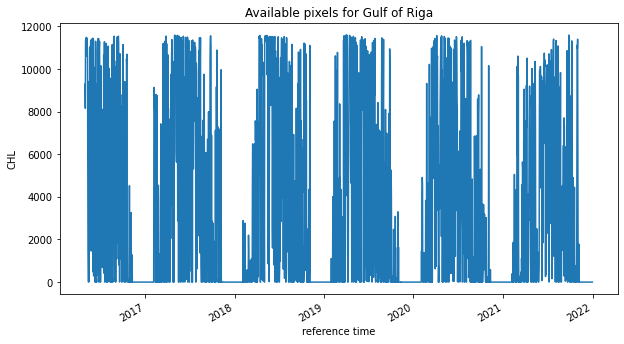

In [ ]:
goRiga_chl_data["CHL"].plot(aspect=2, size=5)
plt.title("Available pixels for Gulf of Riga")

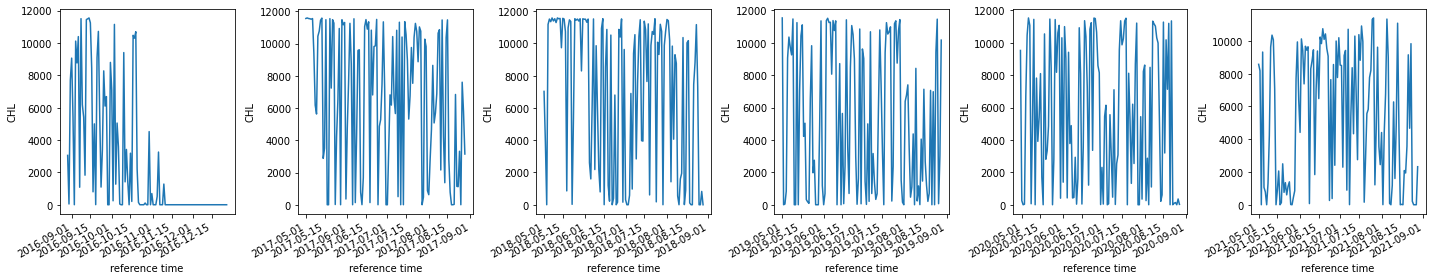

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(20, 4))
for i, yearda in enumerate(goRiga_chl_data.groupby(goRiga_chl_data["time"].dt.year)):
    yearda[1]["CHL"].isel(time=slice(120,240,1)).plot(ax=axes[i], x="time")
plt.tight_layout()

Vizualising the area to make sure it is the correct subset of the data

In [ ]:
goRiga = masked_chl_data.isel(x=range(720,880,1), y= range(330,490,1))

/usr/local/lib/python3.8/dist-packages/xarray/core/indexing.py:1380: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [ ]:
# Calculate the average
goRiga_avg = goRiga.groupby("time.year").mean("time")
goRiga_avg

<xarray.Dataset>
Dimensions:  (year: 6, y: 160, x: 160)
Coordinates:
  * y        (y) float32 56.88 56.89 56.9 56.91 ... 58.59 58.61 58.62 58.63
  * x        (x) float32 22.02 22.04 22.05 22.07 ... 24.78 24.8 24.82 24.84
  * year     (year) int64 2016 2017 2018 2019 2020 2021
Data variables:
    CHL      (year, y, x) float32 dask.array<chunksize=(1, 160, 160), meta=np.ndarray>
Attributes: (12/42)
    Conventions:             CF-1.4
    references:              
    institution:             CNR-GOS
    contact:                 technical@gos.artov.isac.cnr.it
    netcdf_version:          v4
    grid_mapping:            Equirectangular
    ...                      ...
    cmems_product_id:        OCEANCOLOUR_BAL_BGC_L3_MY_009_133
    History:                 Translated to CF-1.0 Conventions by Netcdf-Java ...
    geospatial_lat_min:      53.2554931640625
    geospatial_lat_max:      65.8445053100586
    geospatial_lon_min:      9.25886058807373
    geospatial_lon_max:      30.241138458251953

Inspecting the number of concecutive cloud free days in the area

In [ ]:
def calculate_streak_lengths(ds):
    is_nan = np.isnan(ds['CHL'].values)
    changes = np.diff(is_nan.astype(int))
    start_idxs = np.where(changes == -1)[0]
    end_idxs = np.where(changes == 1)[0]

    streaks = []
    streak_length = 0
    for start, end in zip(start_idxs, end_idxs):
        streak_length = end - start
        streaks.append(streak_length)

    # handle edge cases
    if is_nan[0]:
        streak_length += 1
    if is_nan[-1]:
        streaks.append(streak_length + 1)

    return np.array(streaks)

In [ ]:
max_number_masked_pixels = (goRiga_chl_data['CHL'].values.max())
print(max_number_masked_pixels)
print('and')

11597
and


In [ ]:
cons_streak_days = calculate_streak_lengths(goRiga_chl_data.where(goRiga_chl_data["CHL"] == max_number_masked_pixels))

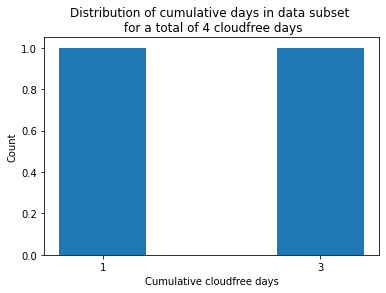

In [ ]:
labels, counts = np.unique(cons_streak_days, return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.title(f"Distribution of cumulative days in data subset \n for a total of {sum(cons_streak_days)} cloudfree days")
plt.ylabel("Count")
plt.xlabel("Cumulative cloudfree days")
plt.show()